## Modelagem Case
#### Modelos de Machine Learning
---
#### Autor: Felipe Cunha

#### Imports

In [70]:
# importando bibliotecas 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

rcParams.update({"figure.figsize" : (12.8,9.6)})

#### Loading Dataset

In [71]:
# carregando dataframe e olhando a estrutura dos dados

df = pd.read_csv('dataset.csv')
df.head()

,Data,Energia_usada,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Dia da Semana,Segunda-feira,Carga leve
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Dia da Semana,Segunda-feira,Carga leve
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Dia da Semana,Segunda-feira,Carga leve
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Dia da Semana,Segunda-feira,Carga leve
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Dia da Semana,Segunda-feira,Carga leve


#### Pré-processamentos

In [72]:
# Transformandos labels e os dados que são strings para o formato de data e em um padrão para facilitar as análises posteriores

df.columns = df.columns.str.lower() 

df['data'] = pd.to_datetime(df['data']) 
df['mes'] = df['data'].dt.month

# Modificando os valores das colunas categóricas para lower case e retirando espaços
# Definindo a função que será aplicada em cada elemento
def lowercase_replace_space(x):
    if isinstance(x, str):
        return x.lower().replace(' ', '_').replace('-', '_')
    else:
        return x

# Aplicando a função em todos os elementos do dataframe que sejam do formato objeto
df = df.applymap(lowercase_replace_space)

- Em primeiro lugar criou-se uma variável chamada "dias_continuos" para agregar os dados dia a dia durante o período de 1 ano;

In [73]:
df['dias_continuos'] = df.data.dt.dayofyear

- Em seguida, transformou-se os dados categóricos em numéricos

In [74]:
from sklearn.preprocessing import OneHotEncoder # Utilizou-se OneHotEncoder nos dados categóricos binários e ordinais das variáveis v7 e v9, respectivamente.

var_cat = ['v7', 'v9']

encoder = OneHotEncoder()
encoder.fit(df[var_cat])

df_encoded = pd.DataFrame(encoder.transform(df[var_cat]).toarray(), columns=encoder.get_feature_names_out(var_cat))

df = pd.concat([df.drop(var_cat, axis=1), df_encoded], axis=1)

#### Testes para previsão do último mês do ano (DEZ)

- O dataframe agregado pelos dias foi criado com as variáveis de interesse. 
    - Foram excluidas as variáveis v3, produção de CO2, pois esta poderia enviesar o modelo devido a sua derivação da variável dependente ("energia_usada")
    - Como foi visto na EDA que não havia uma diferença relevante entre o consumo de energia elétrica entre os dias da semana, apenas entre fim de semana e dia de semana, excluiu-se a variável v8;

In [75]:
# criação do dataframe agrupado por dias
df_agrupado = df.groupby('dias_continuos')[['energia_usada', 'v1', 'v2', 'v4', 'v5', 'v7_dia_da_semana', 'v7_final_de_semana', 'v9_carga_leve', 'v9_carga_maxima', 'v9_carga_media']].sum()

In [76]:
df_agrupado.shape

(365, 10)

- Optou-se por agregar os dados com o método de soma para ter o gasto de energia efetivo durante um dia e não a média de cada dia;
- Separação do dataframe em variáveis independentes (X) e variável dependente (y)

In [77]:
X = df_agrupado.drop('energia_usada', axis=1)
y = df_agrupado.energia_usada

- Em seguida, foram separados o conjunto de treino e de teste; 
    - Conjunto de treino: Dados diários de janeiro a novembro;
    - Conjunto de teste: Dados de dezembro

In [78]:
# separação dos conjuntos de treino e teste
X_train = X.loc[:334,:] # Esses valores do slice foram definidos com base em dezembro ter 31 dias. 365 - 31 = 334 
y_train = y[:334].values

X_test = X.loc[335:,:]
y_test = y[334:].values

In [79]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (334, 9) (334,)
Testing set shape:  (31, 9) (31,)


#### Modelos de Machine Learning

- Serão avaliados dois modelos de regressão:
    - Regressão Linear 
    - KNearestRegressor 

- Os modelos foram escolhidos pela forma com que fazem a regressão:
    - O primeiro utiliza mínimos quadrados para definir retas que representem a relação entre as variáveis independentes e a variável dependente;
    - O segundo utiliza o cálculo de distâncias para definir essa relação.

---

- Definiu-se como métricas para avaliar o modelo:
    - Coeficiente de Determinação (R2);
    - Raiz do erro quadrático médio (RMSE)

---

- Foi definida uma função para avaliação dos modelos em relação a essas métricas e apresentação de um gráfico para visualização do valor real e do valor predito;

In [80]:
def regressao(X_train, y_train, X_test, y_test, model, title):
    if model == 1:
        model = LinearRegression()
    elif model == 2:
        model = KNeighborsRegressor()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f'R2: {r2:.4f} e RMSE: {rmse:.2f}')
    print('')
    print('Energia utilizada efetivamente (Kwh): ', y_test.sum())
    print('')
    print('Previsão do modelo (Kwh): ', round(y_pred.sum(),2))
    print('')
    print('Erro na previsão (Kwh):', round(y_pred.sum() - y_test.sum(),2))

    plt.plot(y_pred, linewidth=3, label='Valor Predito', color='blue', alpha=0.7)
    plt.plot(y_test, linewidth=3, label='Valor Verdadeiro', color='red', alpha=0.7)

    plt.legend()

    plt.xlabel('Dia', fontsize=16)
    plt.ylabel('Energia utilizada (Kwh)', fontsize=16)
    plt.title(title, fontsize=18)

    fig = plt.gcf()
    fig.set_facecolor('#f0f0f0')  # Cor em hexadecimal

    plt.show()

R2: 0.9288 e RMSE: 365.43

Energia utilizada efetivamente (Kwh):  69379.17

Previsão do modelo (Kwh):  76051.06

Erro na previsão (Kwh): 6671.89


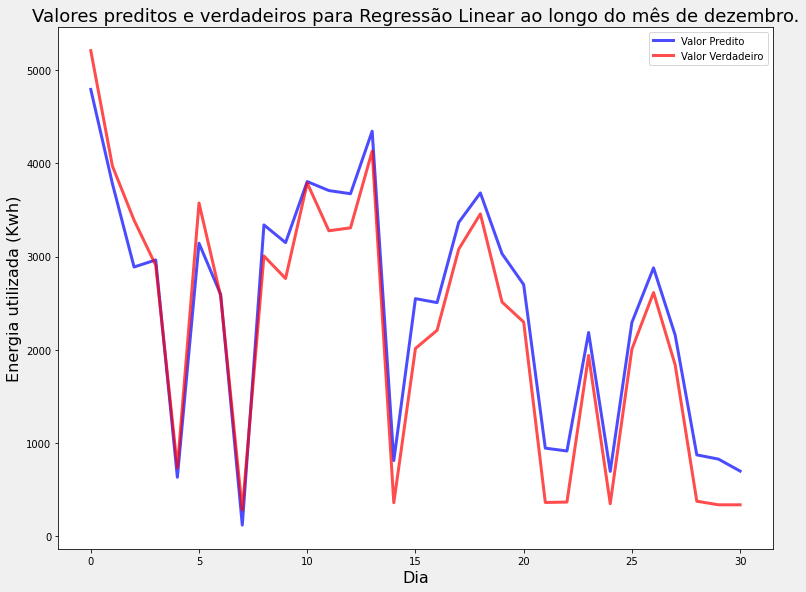

In [81]:
regressao(X_train, y_train, X_test, y_test, 1, 'Valores preditos e verdadeiros para Regressão Linear ao longo do mês de dezembro.')

R2: 0.9603 e RMSE: 272.78

Energia utilizada efetivamente (Kwh):  69379.17

Previsão do modelo (Kwh):  72568.96

Erro na previsão (Kwh): 3189.79


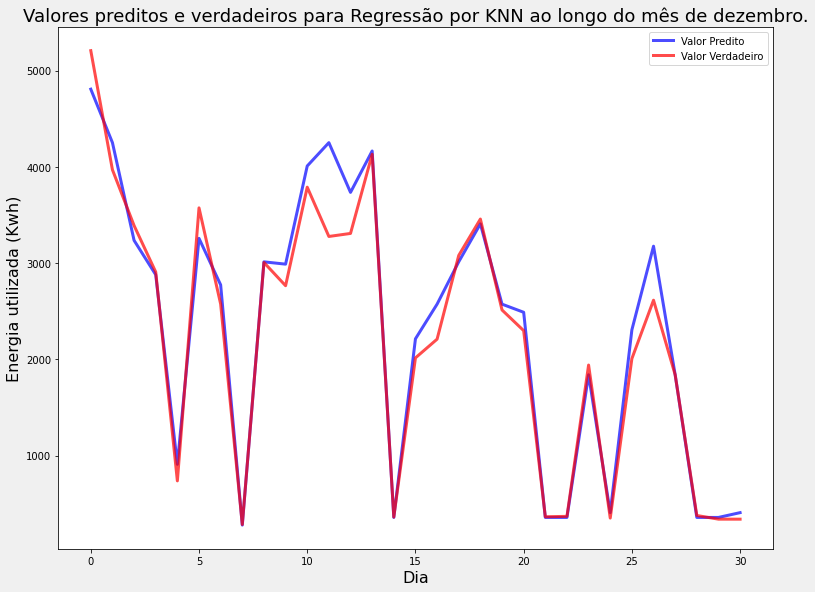

In [82]:
regressao(X_train, y_train, X_test, y_test, 2, 'Valores preditos e verdadeiros para Regressão por KNN ao longo do mês de dezembro.' )

- Comparando-se os dois modelos iniciais percebeu-se que o KNN teve um melhor resultado de previsão do gasto de energia em comparação com o modelo de regressão linear;
- O KNN teve um erro médio quadrático de 273 Kwh contra 366 Kwh por dia do modelo linear;
- Em relação ao mês. que é o objetivo dessa análise, houve uma diferença de 6672 Kwh do modelo linear para o valor real; E uma diferença de 3190 Kwh do modelo KNN para o valor real, uma performance bem superior;

---

- Antes de definir o melhor modelo, verificou-se se o número de variáveis era o mais adequado para uma melhor performance do modelo

In [83]:


def best_subset(X_train, y_train, X_test, y_test, max_features=None, models=["linear", "knn"], knn_neighbors=5):
    """
    Encontra o melhor subconjunto de variáveis para otimizar um modelo de regressão linear e um modelo de KNN em função do coeficiente de determinação (R²).

    Parameters:
        X_train (array-like): array com as variáveis independentes de treino
        y_train (array-like): array com a variável dependente de treino
        X_test (array-like): array com as variáveis independentes de teste
        y_test (array-like): array com a variável dependente de teste
        max_features (int, optional): número máximo de variáveis a serem testadas em cada modelo (default = None)
        models (list, optional): lista com os modelos a serem testados (default = ["linear", "knn"])
        knn_neighbors (int, optional): número de vizinhos a serem considerados no modelo de KNN (default = 5)

    Returns:
        results (dict): dicionário com os resultados dos modelos para cada subconjunto de variáveis testado
    """
    # Define as combinações de variáveis a serem testadas
    if max_features is None:
        max_features = X_train.shape[1]
    feature_combinations = []
    for i in range(1, max_features+1):
        feature_combinations += combinations(range(X_train.shape[1]), i)
    feature_combinations = list(feature_combinations)

    # Inicializa o dicionário de resultados
    results = {}

    # Testa o modelo de regressão linear
    if "linear" in models:
        linreg = LinearRegression()
        linreg_scores = []
        for features in feature_combinations:
            X_train_sub = X_train[:, features]
            X_test_sub = X_test[:, features]
            linreg.fit(X_train_sub, y_train)
            y_pred = linreg.predict(X_test_sub)
            scores = r2_score(y_test, y_pred)
            linreg_scores.append((features, scores))
        results["linear"] = linreg_scores

    # Testa o modelo de KNN
    if "knn" in models:
        knn = KNeighborsRegressor(n_neighbors=knn_neighbors)
        knn_scores = []
        for features in feature_combinations:
            X_train_sub = X_train[:, features]
            X_test_sub = X_test[:, features]
            knn.fit(X_train_sub, y_train)
            y_pred = knn.predict(X_test_sub)
            scores = r2_score(y_test, y_pred)
            knn_scores.append((features, scores))
        results["knn"] = knn_scores

    return results

results = best_subset(np.array(X_train), y_train, np.array(X_test), y_test)

In [84]:
# Obtém as 5 melhores combinações de variáveis para cada modelo
for model_name, model_scores in results.items():
    sorted_scores = sorted(model_scores, key=lambda x: x[1], reverse=True)[:5]
    print(f"{model_name.upper()}")
    for i, score in enumerate(sorted_scores):
        print(f"  {i+1}. Features: {score[0]}, R²: {score[1]:.4f}")

LINEAR
  1. Features: (0, 1, 3, 7), R²: 0.9450
  2. Features: (0, 1, 3, 8), R²: 0.9450
  3. Features: (0, 1, 3, 6, 7, 8), R²: 0.9450
  4. Features: (0, 1, 3, 6), R²: 0.9450
  5. Features: (0, 1, 3, 6, 7), R²: 0.9450
KNN
  1. Features: (0, 1, 2), R²: 0.9669
  2. Features: (0, 1, 2, 6), R²: 0.9669
  3. Features: (0, 1, 2, 7), R²: 0.9669
  4. Features: (0, 1, 2, 8), R²: 0.9669
  5. Features: (0, 1, 2, 6, 7), R²: 0.9669


- Como pode-se observar, para o modelo linear, apenas 4 variáveis são necessárias para se obter um R2 superior ao com todas as variáveis. 
    - São elas: 
        - v1 - corrente atrasada
        - v2 - corrente principal
        - v5 - fator de potência atual principal
        - A quarta pode ser qualquer uma das cargas
- Já para o modelo KNN, o melhor resultado se deu com apenas 3 variáveis:
    - São elas:
        - v1 - corrente atrasada
        - v2 - corrente principal
        - v4 - fator de potência atual atrasado

--- 

- Em seguida, resolveu-se otimizar os parâmetros do modelo KNN para verificar se os resultados melhorariam;

In [85]:
best_cols = ['v1', 'v2', 'v4']
best_X_train = X_train[best_cols]
best_X_test = X_test[best_cols]

R2: 0.9669 e RMSE: 249.20

Energia utilizada efetivamente (Kwh):  69379.17

Previsão do modelo (Kwh):  70422.83

Erro na previsão (Kwh): 1043.66


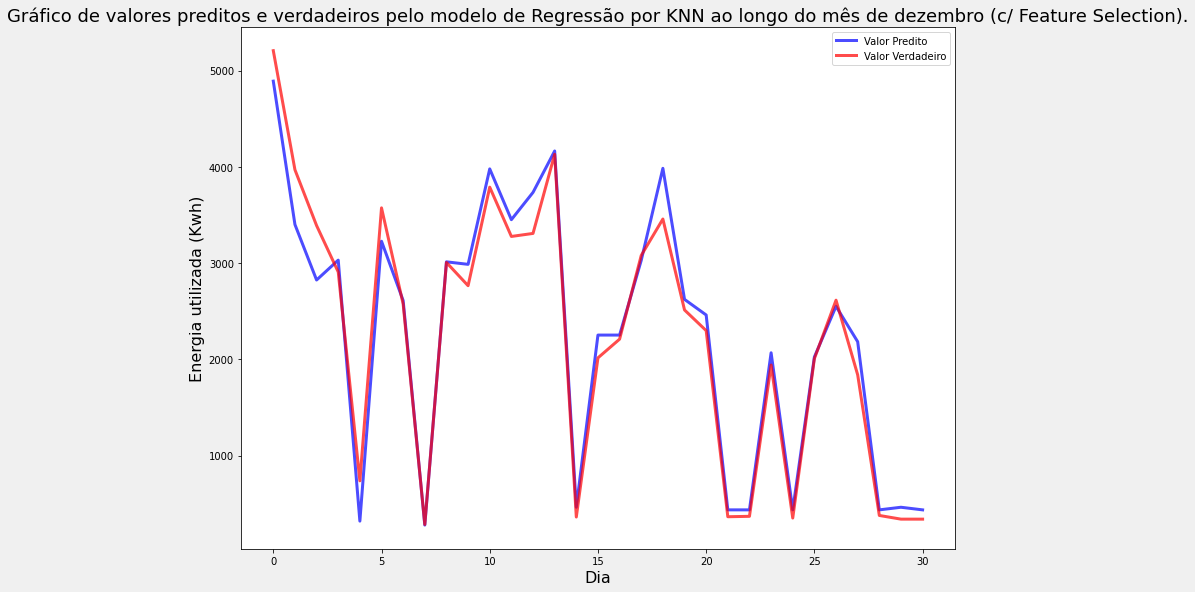

In [86]:
regressao(best_X_train, y_train, best_X_test, y_test, 2, 'Gráfico de valores preditos e verdadeiros pelo modelo de Regressão por KNN ao longo do mês de dezembro (c/ Feature Selection).' )

- Com a seleção de variáveis, houve uma melhora no modelo;
- Com apenas 3 variáveis o modelo obteve um erro de predição para o mês de dezembro de cerca 1000 Kwh, três vezes menor que o modelo anterior com todas as variáveis;
---
- Em seguida, será testada a otimização de hiperparâmetros visando melhorar ainda mais a performance do modelo.

In [87]:
# Definir o modelo KNN
knn_model = KNeighborsRegressor()

# Definir os parâmetros a serem testados

knn_params = {
    'n_neighbors': [7,9,11,13],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=knn_model, param_grid=knn_params, scoring='r2', cv=5)

# Treinar o modelo com os dados de treino
grid_search.fit(best_X_train, y_train)

# Imprimir os resultados
print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Melhor score: {grid_search.best_score_:.4f}")


Melhores parâmetros: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Melhor score: 0.9217


In [88]:
best_pred = grid_search.predict(best_X_test)

 R2: 0.9691 e RMSE: 240.63

Energia utilizada efetivamente (Kwh):  69379.17

Previsão do modelo (Kwh):  71641.0

Erro na previsão (Kwh): 2261.83


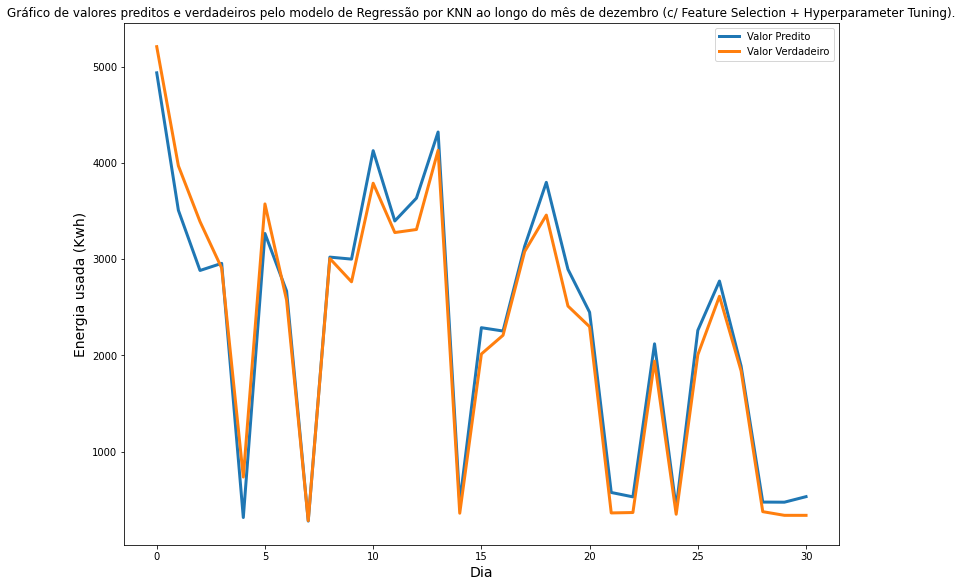

In [89]:
r2_best_knn = r2_score(y_test, best_pred)

rmse_best_knn = mean_squared_error(y_test, best_pred, squared=False)

print(f' R2: {r2_best_knn:.4f} e RMSE: {rmse_best_knn:.2f}')
print('')
print('Energia utilizada efetivamente (Kwh): ', y_test.sum())
print('')
print('Previsão do modelo (Kwh): ', round(best_pred.sum(),2))
print('')
print('Erro na previsão (Kwh):', round(best_pred.sum() - y_test.sum(),2))

plt.plot(best_pred, linewidth=3, label='Valor Predito')
plt.plot(y_test, linewidth=3, label='Valor Verdadeiro')
plt.legend()
plt.xlabel('Dia', fontsize=14)
plt.ylabel('Energia usada (Kwh)', fontsize=14)
plt.title('Gráfico de valores preditos e verdadeiros pelo modelo de Regressão por KNN ao longo do mês de dezembro (c/ Feature Selection + Hyperparameter Tuning).', fontsize=12)
plt.show()

- A otimização dos parâmetros do modelo não foi eficiente e piorou o resultado geral das previsões. 

---

- Em seguida será feito mais um teste com as features selecionadas e utilizando o conjunto de dados sem outliers que foi definido na EDA;

In [90]:
df_sem_outliers = df[df['energia_usada'] > 19] # Na EDA foi observado que dados menores que 19 Kwh eram relativos a momentos em que a fabrica não estava em funcionamento
df_sem_outliers = df_sem_outliers[df_sem_outliers['energia_usada'] <= 123.30] # Também observou-se que haviam outliers no limite superior

In [91]:
df_sem_outliers = df[df['energia_usada'] <= 123.30]
df_sem_outliers.head()

,data,energia_usada,v1,v2,v3,v4,v5,v6,v8,mes,dias_continuos,v7_dia_da_semana,v7_final_de_semana,v9_carga_leve,v9_carga_maxima,v9_carga_media
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,segunda_feira,1,1,1.0,0.0,1.0,0.0,0.0
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,segunda_feira,1,1,1.0,0.0,1.0,0.0,0.0
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,segunda_feira,1,1,1.0,0.0,1.0,0.0,0.0
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,segunda_feira,1,1,1.0,0.0,1.0,0.0,0.0
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,segunda_feira,1,1,1.0,0.0,1.0,0.0,0.0


In [92]:
df_sem_outliers.shape

(34715, 16)

In [93]:
# Mesmos tratamentos realizandos anteriormente
df_agg_sem_outliers = df_sem_outliers.groupby('dias_continuos')[['energia_usada', 'v1', 'v2', 'v4', 'v5', 'v7_dia_da_semana', 'v7_final_de_semana', 'v9_carga_leve', 'v9_carga_maxima', 'v9_carga_media']].sum()

In [94]:
X = df_agg_sem_outliers.drop('energia_usada', axis=1)
y = df_agg_sem_outliers['energia_usada']

In [95]:
X_train = X.loc[:334,:]
y_train = y[:286].values

X_test = X.loc[335:,:]
y_test = y[286:].values  

In [96]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (334, 9) (286,)
Testing set shape:  (31, 9) (79,)


In [97]:
X_train = X_train[best_cols]
X_test = X_test[best_cols]

In [98]:
regressao(X_train, y_train, X_test, y_test, 2, 'Valores preditos e verdadeiros para modelo otimizado.')

ValueError: Found input variables with inconsistent numbers of samples: [334, 286]

- Percebe-se que o modelo sem outliers e com as variáveis selecionadas foi o que obteve o menor erro na previsão para o mês de dezembro, mesmo com o R² mais baixo.

#### Testes de previsão para 2 meses (NOV e DEZ)

In [ ]:
treino = df_sem_outliers.loc[~df_sem_outliers.mes.isin([11, 12])]
teste = df_sem_outliers[df_sem_outliers.mes.isin([11,12])]

In [ ]:
X_train = treino.groupby('dias_continuos')[['v1', 'v2', 'v4']].sum()
y_train = treino.groupby('dias_continuos')['energia_usada'].sum().values

X_test = teste.groupby('dias_continuos')[['v1', 'v2', 'v4']].sum()
y_test = teste.groupby('dias_continuos')['energia_usada'].sum().values

In [ ]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (260, 3) (260,)
Testing set shape:  (50, 3) (50,)


R2: 0.8165 e RMSE: 358.57

Energia utilizada efetivamente em NOV (Kwh): 75844.15. Energia utilizada efetivamente em DEZ (Kwh): 57316.86

Previsão do modelo para NOV (Kwh): 75700.66. Previsão do modelo para DEZ (Kwh): 57308.9

Erro na previsão NOV (Kwh): 143.49. Erro na previsão DEZ (Kwh): 7.96


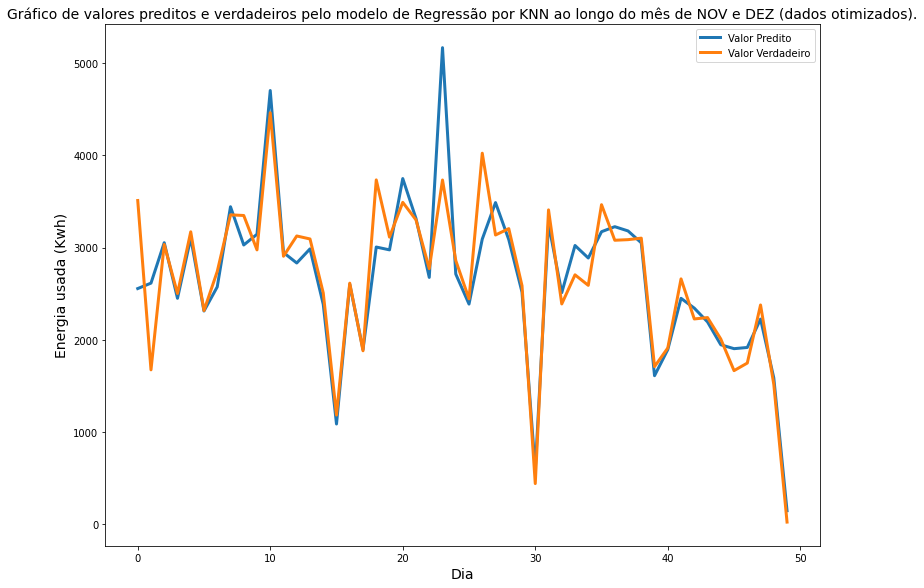

In [ ]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
knn_pred = model.predict(X_test)     
r2_knn = r2_score(y_test, knn_pred)
rmse_knn = mean_squared_error(y_test, knn_pred, squared=False)

print(f'R2: {r2_knn:.4f} e RMSE: {rmse_knn:.2f}')
print('')
print(f'Energia utilizada efetivamente em NOV (Kwh): {y_test[:26].sum()}. Energia utilizada efetivamente em DEZ (Kwh): {y_test[26:].sum()}')
print('')
print(f'Previsão do modelo para NOV (Kwh): {round(knn_pred[:26].sum(),2)}. Previsão do modelo para DEZ (Kwh): {round(knn_pred[26:].sum(),2)}')
print('')
print(f'Erro na previsão NOV (Kwh): {abs(round(knn_pred[:26].sum() - y_test[:26].sum(),2))}. Erro na previsão DEZ (Kwh): {abs(round(knn_pred[26:].sum() - y_test[26:].sum(),2))}')

plt.plot(knn_pred, linewidth=3, label='Valor Predito')
plt.plot(y_test, linewidth=3, label='Valor Verdadeiro')
plt.legend()
plt.xlabel('Dia', fontsize=14)
plt.ylabel('Energia usada (Kwh)', fontsize=14)
plt.title('Gráfico de valores preditos e verdadeiros pelo modelo de Regressão por KNN ao longo do mês de NOV e DEZ (dados otimizados).', fontsize=14)
plt.show()

- Além dos testes abordados no projeto, foram feitos testes com escalonamento dos dados, o que não resultou na melhoria da performance; 

#### Conclusões

- Foi possível construir um modelo com KNN com as variáveis "Corrente Atrasada (v1), Corrente Principal (v2) e Fator de Potência Atual Atrasado (v4) com bons resultados de previsão para um mês, com erro médio nesse período de 231 Kwh;
- Para chegar a tal resultado, treinou-se o modelo com dados dos meses de janeiro a novembro e previu-se o mês de dezembro;

Modelo | Pré-processamento | r^2 | RMSEP (Khw) | Erro Mensal (Kwh)
--- | --- | --- | --- | --- 
LR | Nenhum | 0.9288 | 365 | 6672
KNN | Nenhum | 0.9603 | 273 | 3190
KNN | Feature Selection (FS) | 0.9669 | 249 | 1044
KNN | FS + Hyperparameter Tuning | 0.9691 | 240 | 2262
**KNN** | **FS + Retirada Outliers** | **0.9147** | **266** | **231**

- Também foi possível fazer testes para um período de previsão de 2 meses com resultados interessantes. O erro para os meses em conjunto ficou em 152 Khw.
- Para tal, treinou-se o modelo com dados de janeiro a outubro e tentou se prever novembro e dezembro;

- Por fim, entende-se que é necessário retreinar o modelo mês a mês, porém é possível seu retreino a cada 2 meses como visto nos resultados.
